In [5]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
from torchvision.models import resnet18
import torch
import torchvision.transforms as transforms
import seaborn as sns
from sklearn.metrics import confusion_matrix
import torch.optim as optim
from torch.utils.data import RandomSampler
import numpy  as np 
import torchvision.models as models
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
from torch.utils.data import Subset
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.optim.lr_scheduler as lr_scheduler
from torchvision import datasets, transforms

from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import label_binarize



## Sort out data from different sources

In [6]:
root_dir = 'C:/Users/saboo/Downloads/data/train'

transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224x3 (3 for RGB)
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(), # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

print("transoforming data")
datasets = datasets.ImageFolder(root=root_dir, transform=transform)

transoforming data


In [7]:
#split the dataset into train test val
train_test_val_split = [0.7, 0.15, 0.15]
# train_data, test_full_data = train_test_split(datasets, test_size=val_ratio+test_ratio, random_state=42)
# val_data, test_data = train_test_split(test_full_data, test_size=test_ratio/(test_ratio + val_ratio), random_state=42)
train_data, test_data, val_data = torch.utils.data.random_split(datasets,
                                    [round(p * len(datasets)) for p in train_test_val_split],
                                    generator=torch.Generator().manual_seed(42))

print(f"Training data length: {len(train_data)}, validation data length {len(val_data)}, test data length {len(test_data)}")

Training data length: 60900, validation data length 13050, test data length 13050


In [8]:
# create dataloader for each split
train_loader = DataLoader(train_data, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False, num_workers=4)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False, num_workers=4)

In [10]:
from torchvision import datasets, transforms
train_dataset = datasets.ImageFolder(root=root_dir, transform=transform)
class_names = train_dataset.classes
num_classes = len(class_names)
print("Available classes:")
print(class_names)
print(num_classes)

Available classes:
['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']
29


In [9]:
# use gpu if possible
device = 'cpu'
device = torch.device("cuda:0" if torch.cuda.is_available() else device)
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("mps" if torch.backends.mps.is_available() else device)
print(device)

cuda:0


In [15]:
import timm
import torch

# Load an EfficientNet model pre-trained on ImageNet
model = timm.create_model('efficientnet_b0', pretrained=True, num_classes=29)

# Move the model to the GPU
model = model.to(device)
import torch.optim as optim

optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()


In [16]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=5):
    for epoch in range(num_epochs):
        # Training phase
        model.train()  # Set model to training mode
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

        train_loss /= len(train_loader.dataset)
        train_accuracy = 100 * train_correct / train_total

        # Validation phase
        model.eval()  # Set model to evaluate mode
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_loss /= len(val_loader.dataset)
        val_accuracy = 100 * val_correct / val_total

        print(f'Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, '
              f'Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%')

 
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=5)


Epoch 1: Train Loss: 0.4259, Train Acc: 86.46%, Val Loss: 0.2458, Val Acc: 93.82%
Epoch 2: Train Loss: 0.0884, Train Acc: 97.24%, Val Loss: 0.1374, Val Acc: 96.15%
Epoch 3: Train Loss: 0.0672, Train Acc: 98.03%, Val Loss: 0.0702, Val Acc: 97.71%
Epoch 4: Train Loss: 0.0548, Train Acc: 98.44%, Val Loss: 0.0263, Val Acc: 99.19%
Epoch 5: Train Loss: 0.0429, Train Acc: 98.85%, Val Loss: 0.0334, Val Acc: 99.00%


In [17]:
def evaluate_model(model, test_loader, criterion):
    model.eval()  # Set the model to evaluation mode
    test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100 * correct / total
    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

# Evaluate the model
evaluate_model(model, test_loader, criterion)



Test Loss: 0.0299, Test Accuracy: 99.08%


In [24]:
# Epoch data
epochs = np.arange(1, 6)
train_loss = np.array([0.4259, 0.0884, 0.0672, 0.0548, 0.0429])
train_accuracies = np.array([86.46, 97.24, 98.03, 98.44, 98.85]) / 100
val_loss = np.array([0.2458, 0.1374, 0.0702, 0.0263, 0.0334])
val_accuracies = np.array([93.82, 96.15, 97.71, 99.19, 99.00]) / 100


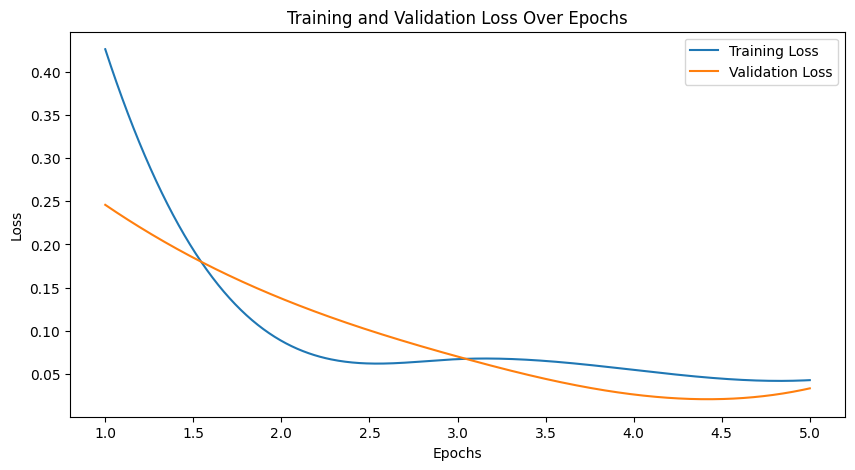

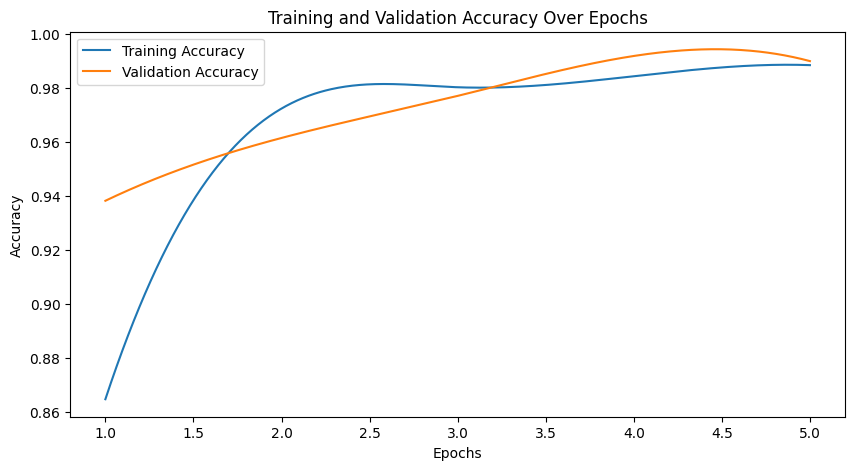

In [25]:
from scipy.interpolate import make_interp_spline, BSpline

# function to smooth the data
def smooth_data(x, y, points=500):
    xnew = np.linspace(x.min(), x.max(), points) 
    spl = make_interp_spline(x, y, k=3)  # type: BSpline
    ynew = spl(xnew)
    return xnew, ynew


epochs_smooth, train_loss_smooth = smooth_data(epochs, train_loss)
_, val_loss_smooth = smooth_data(epochs, val_loss)
_, train_accuracies_smooth = smooth_data(epochs, train_accuracies)
_, val_accuracies_smooth = smooth_data(epochs, val_accuracies)

# Plot training loss and validation loss
plt.figure(figsize=(10, 5))
plt.plot(epochs_smooth, train_loss_smooth, label='Training Loss')
plt.plot(epochs_smooth, val_loss_smooth, label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training accuracy and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(epochs_smooth, train_accuracies_smooth, label='Training Accuracy')
plt.plot(epochs_smooth, val_accuracies_smooth, label='Validation Accuracy')
plt.title('Training and Validation Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [26]:
def evaluate_model(model, data_loader): # function to for test model
    model.eval() # set the model to evaluation mode
    all_predictions = []
    all_labels = []
    # disable gradient calculation
    with torch.no_grad():
        for images, labels in data_loader:
            # move images and labels to the device
            images = images.to(device)
            labels = labels.to(device)
            # forward pass
            outputs = model(images)
            # get the predicted class labels
            _, predictions = torch.max(outputs, 1)

            # extend the lists with predictions and labels
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return all_predictions, all_labels

In [84]:
# test_dir = 'data/train'
# # Create the test dataset using ImageFolder
# test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)

# # Create the test dataloader
# test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

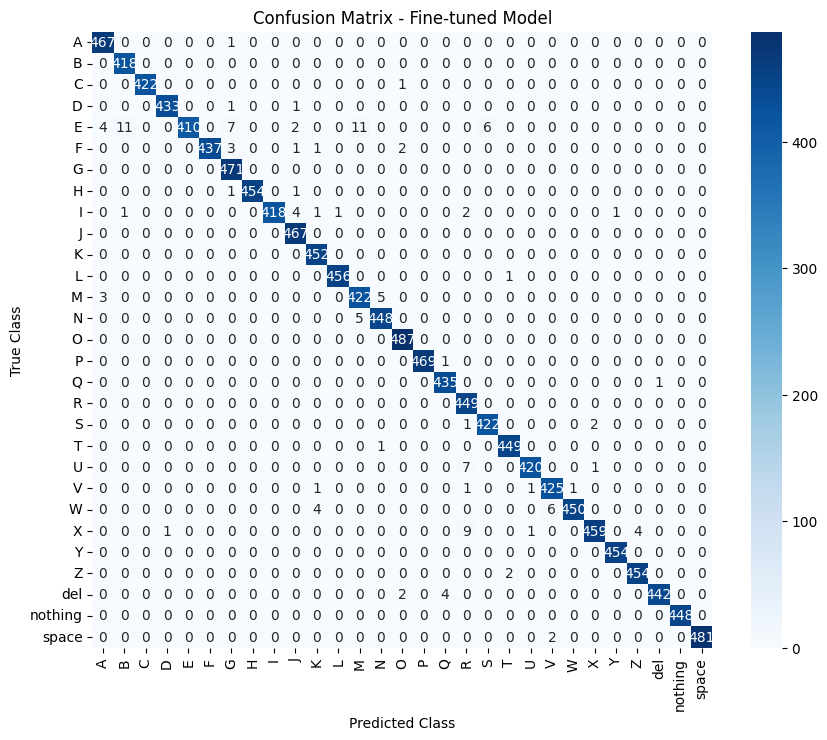

In [28]:
model.eval()
fine_tuned_predictions, fine_tuned_labels = evaluate_model(model, test_loader)

# calculate accuracy scores
fine_tuned_accuracy = accuracy_score(fine_tuned_labels, fine_tuned_predictions)

print("Fine-tuned model accuracy on testing set:", fine_tuned_accuracy)
# Generate confusion matrix 
conf_matrix = confusion_matrix(fine_tuned_labels, fine_tuned_predictions)

class_names = class_names

# Plot confusion matrix 
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix - Fine-tuned Model")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.show()

In [31]:
# Define a function to evaluate the model and get predicted probabilities
def get_predicted_probs_and_labels(model, data_loader):
    model.eval()
    all_probs = []
    all_labels = []
    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)
            all_probs.append(probs.cpu().numpy())
            all_labels.append(labels.numpy())
    return np.concatenate(all_probs), np.concatenate(all_labels)

# Compute predicted probabilities for the fine-tuned model on the test data
predicted_probs, true_labels = get_predicted_probs_and_labels(model, test_loader)

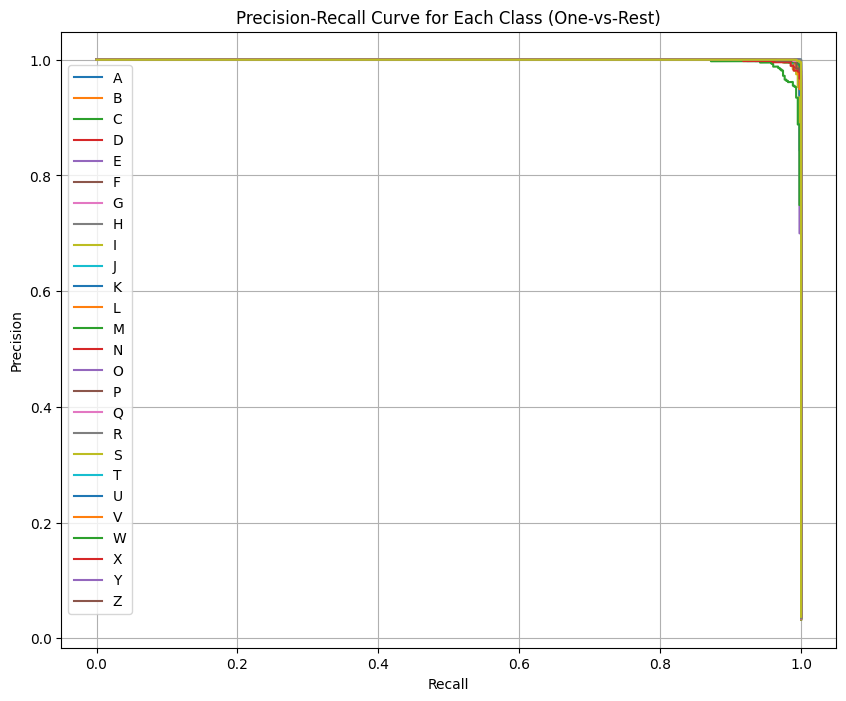

In [33]:
import string
# Convert 'fine_tuned_labels' to one-hot encoded form
binarized_labels = label_binarize(fine_tuned_labels, classes=np.unique(fine_tuned_labels))

# Compute precision-recall pairs for each class
precisions = dict()
recalls = dict()
labels = list(string.ascii_uppercase)
for i in range(num_classes):
    precisions[i], recalls[i], _ = precision_recall_curve(binarized_labels[:, i], predicted_probs[:, i])

# Plot precision-recall curves for each class
plt.figure(figsize=(10, 8))
for i in range(num_classes):
    plt.plot(recalls[i], precisions[i])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(labels,loc='center left')
plt.title('Precision-Recall Curve for Each Class (One-vs-Rest)')
plt.grid(True)
plt.show()

In [35]:
pip install torchsummary

Note: you may need to restart the kernel to use updated packages.


In [37]:
from torchsummary import summary

# Assuming your_model is your model
# your_model = ...

# You also need to know the input size to your model
# For example, for an image model, it might be something like (3, 224, 224)
# input_size = (3, 224, 224)

your_model = model.to(device)  # Move the model to the device
input_size = (3, 224, 224)
summary(your_model, input_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
          Identity-2         [-1, 32, 112, 112]               0
              SiLU-3         [-1, 32, 112, 112]               0
    BatchNormAct2d-4         [-1, 32, 112, 112]              64
            Conv2d-5         [-1, 32, 112, 112]             288
          Identity-6         [-1, 32, 112, 112]               0
              SiLU-7         [-1, 32, 112, 112]               0
    BatchNormAct2d-8         [-1, 32, 112, 112]              64
            Conv2d-9              [-1, 8, 1, 1]             264
             SiLU-10              [-1, 8, 1, 1]               0
           Conv2d-11             [-1, 32, 1, 1]             288
          Sigmoid-12             [-1, 32, 1, 1]               0
    SqueezeExcite-13         [-1, 32, 112, 112]               0
           Conv2d-14         [-1, 16, 1

In [40]:
test_dir = 'C:/Users/saboo/Downloads/data/test'


print("transoforming data")
actual_test_datset = datasets.ImageFolder(root=test_dir, transform=transform)

actua_test_loader = DataLoader(actual_test_datset, batch_size=32, shuffle=False, num_workers=4)

transoforming data


In [41]:
def evaluate_model(model, test_loader, criterion):
    model.eval()  # Set the model to evaluation mode
    test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100 * correct / total
    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

# Evaluate the model
evaluate_model(model, actua_test_loader, criterion)

Test Loss: 14.2985, Test Accuracy: 28.90%


Fine-tuned model accuracy on testing set: 0.2744329319518342


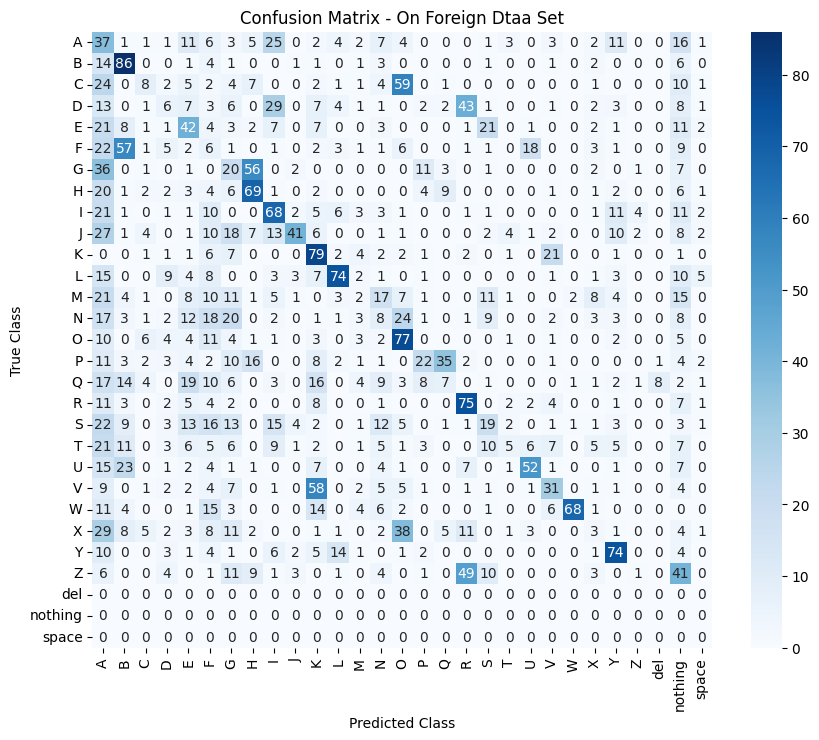

In [46]:
def evaluate_model(model, data_loader): # function to for test model
    model.eval() # set the model to evaluation mode
    all_predictions = []
    all_labels = []
    # disable gradient calculation
    with torch.no_grad():
        for images, labels in data_loader:
            # move images and labels to the device
            images = images.to(device)
            labels = labels.to(device)
            # forward pass
            outputs = model(images)
            # get the predicted class labels
            _, predictions = torch.max(outputs, 1)

            # extend the lists with predictions and labels
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return all_predictions, all_labels
model.eval()
fine_tuned_predictions, fine_tuned_labels = evaluate_model(model, actua_test_loader)

# calculate accuracy scores
fine_tuned_accuracy = accuracy_score(fine_tuned_labels, fine_tuned_predictions)

print("Fine-tuned model accuracy on testing set:", fine_tuned_accuracy)
# Generate confusion matrix 
conf_matrix = confusion_matrix(fine_tuned_labels, fine_tuned_predictions)

class_names = class_names

# Plot confusion matrix 
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix - On Foreign Dtaa Set")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.show()